# Updated Finsler Fire Spread Model (Deterministic, Time‑Aware)

Compatible with the **new deterministic Finsler model** (`fire_model/finsler.py`).

This notebook demonstrates:
- Environment setup (fuel, value, wind, ROS)
- Deterministic Finsler arrival-time evolution
- Retardant drops and **retardant half‑life decay**
- Fire boundary extraction (isochrone boundary)
- A fully working **Bayesian Optimisation** loop for choosing a retardant drop (deterministic objective)


In [1]:
import numpy as np
from matplotlib import pyplot as plt

from fire_model.ca import FireEnv
from fire_model.finsler import FinslerFireModel


## 1. Environment

We build a spatially varying **fuel** and **value** map, plus a wind field. Retardant parameters include a **half‑life** (seconds).

In [2]:
# Grid / domain
nx = ny = 90
domain_km = 2.7

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 60.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.32                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)
drop_w_km = 0.18
drop_h_km = 0.9
drop_amount = 2.0

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
value = 1.0 + 3.0 * np.exp(-4.0 * ((xs - 0.2) ** 2 + (ys + 0.1) ** 2))

# Wind: either constant (nx,ny,2) OR time varying (T,nx,ny,2).
wind = np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 3.5
wind[..., 1] = 0.5 + 0.8 * xs[:, 0][:, None]

# Simple slope field: gentle ridge along +x with downhill toward +y
slope = np.zeros((nx, ny, 2), dtype=float)
slope[..., 0] = 0.3 * xs  # slope component aligned with x
slope[..., 1] = -0.15 * ys  # downhill when y increases

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    drop_w_km=drop_w_km,
    drop_h_km=drop_h_km,
    drop_amount=drop_amount,
    ros_mps=ros_mps,
    slope=slope,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
)


## 2. Model + plotting helpers

In [3]:
finsler = FinslerFireModel(env, diag=True, k_wind=0.45, w_ref=5.0, k_slope=0.35)

def plot_field(field2d, title, cmap=None):
    plt.figure(figsize=(6, 5))
    im = plt.imshow(field2d.T, origin="lower", aspect="equal", cmap=cmap)
    plt.colorbar(im)
    plt.title(title)
    plt.xlabel("x cell")
    plt.ylabel("y cell")
    plt.tight_layout()
    plt.show()

def plot_firestate(state, kind="affected", title=None):
    if kind == "burning":
        field = state.burning[0]
    elif kind == "burned":
        field = state.burned[0]
    elif kind == "affected":
        field = (state.burning[0] > 0.5) | (state.burned[0] > 0.5)
        field = field.astype(float)
    elif kind == "retardant":
        field = state.retardant[0]
    elif kind == "burn_remaining_s":
        field = state.burn_remaining_s[0]
    else:
        raise ValueError("kind must be one of: burning, burned, affected, retardant, burn_remaining_s")
    plot_field(field, title or f"{kind}")


## 3. Baseline evolution (no retardant)

We ignite a small circular patch, evolve to a **drop time**, then evolve forward to a later evaluation time.

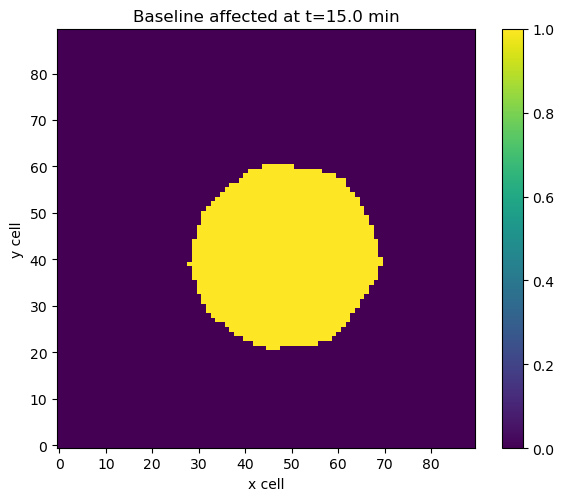

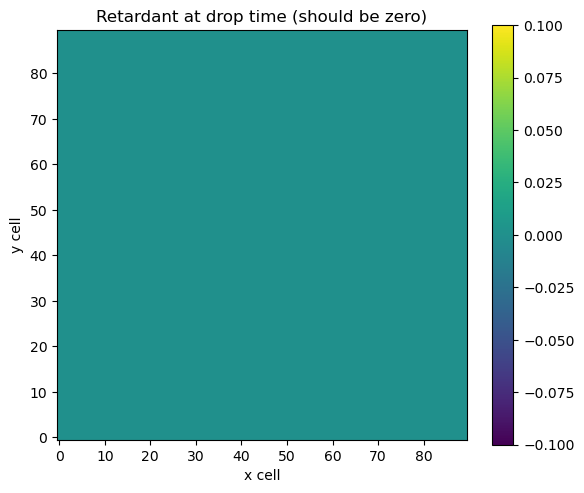

In [4]:
ignition_center = (nx // 2, ny // 2 - 6)
ignition_radius_km = 0.2

drop_time_s = 15 * 60      # when a drop would occur (seconds after ignition)
eval_horizon_s = 45 * 60   # evaluation horizon after drop_time_s

# State at drop time (no retardant)
init_state = finsler.simulate_from_ignition(
    T=drop_time_s,
    center=ignition_center,
    radius_km=ignition_radius_km,
    drone_params=None,
    start_time_s=0.0,
)

plot_firestate(init_state, kind="affected", title=f"Baseline affected at t={drop_time_s/60:.1f} min")
plot_firestate(init_state, kind="retardant", title="Retardant at drop time (should be zero)")


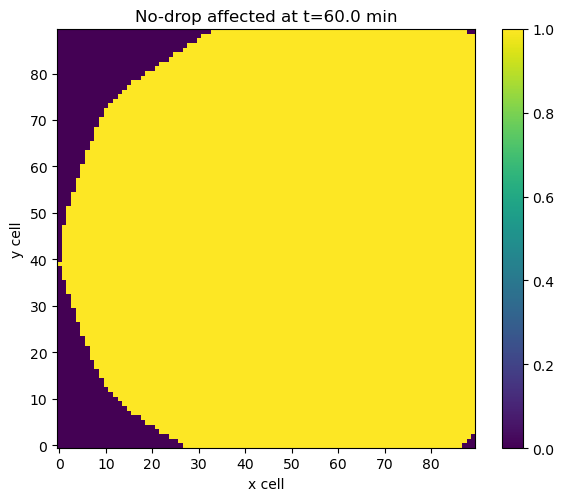

In [5]:
state_no_drop = finsler.simulate_from_firestate(
    init_state,
    T=eval_horizon_s,
    drone_params=None,
)

plot_firestate(state_no_drop, kind="affected", title=f"No-drop affected at t={(drop_time_s+eval_horizon_s)/60:.1f} min")


## 4. Retardant drop + half-life decay

We apply a single rectangular drop and inspect:
- fire evolution impact
- retardant field decay over time


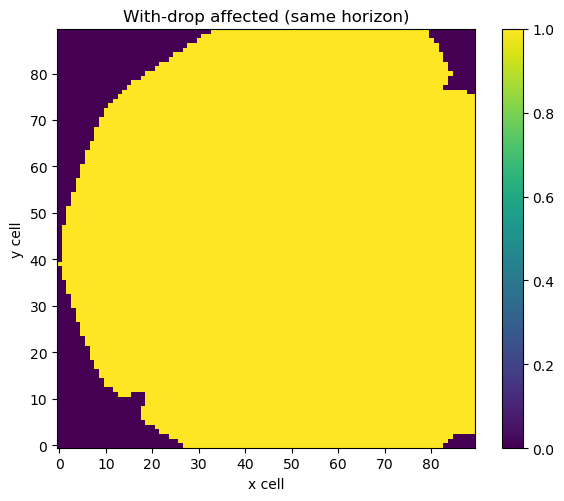

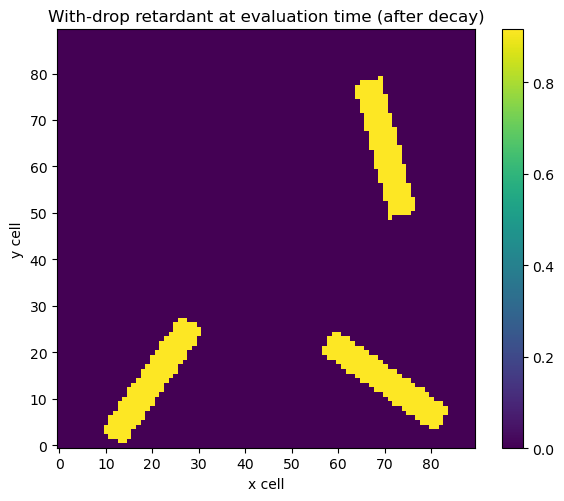

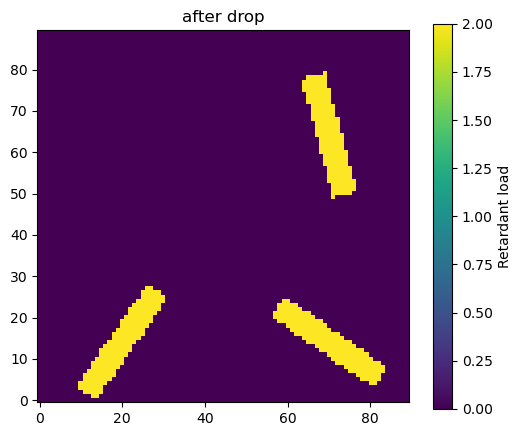

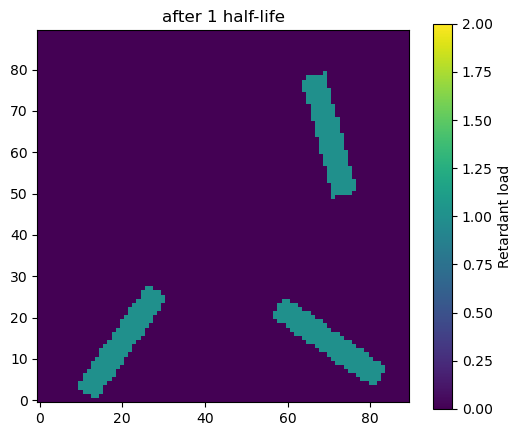

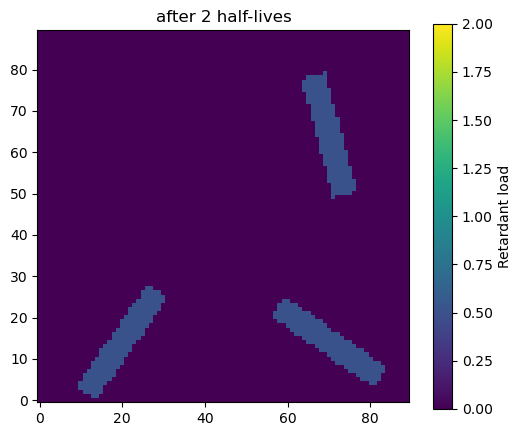

In [6]:
# Three drone parameters: (x0, y0, phi)
# Roughly bracket the active front with different headings
demo_drone_params = np.array([
    (ignition_center[0] + 25, ignition_center[1] + 25, np.deg2rad(15)),
    (ignition_center[0] - 25, ignition_center[1] - 25, np.deg2rad(-35)),
    (ignition_center[0] + 25, ignition_center[1] - 25, np.deg2rad(55)),
], dtype=float)

state_with_drop = finsler.simulate_from_firestate(
    init_state,
    T=eval_horizon_s,
    drone_params=demo_drone_params,
)

plot_firestate(state_with_drop, kind="affected", title="With-drop affected (same horizon)")
plot_firestate(state_with_drop, kind="retardant", title="With-drop retardant at evaluation time (after decay)")

# Visualise decay explicitly by querying the firestate at multiple absolute times.
t_abs0 = drop_time_s
t_abs1 = drop_time_s + retardant_half_life_s
t_abs2 = drop_time_s + 2 * retardant_half_life_s

# Re-run from ignition to ensure we view the drop starting at drop time
_ = finsler.simulate_from_ignition(T=drop_time_s, center=ignition_center, radius_km=ignition_radius_km)
# apply drop starting at t=drop_time_s
finsler.reset_retardant()
finsler._start_time_s = drop_time_s
finsler._retardant_t0_s = drop_time_s
finsler.apply_retardant_cartesian(demo_drone_params)
finsler.init_state(center=ignition_center, radius_km=ignition_radius_km)

st0 = finsler.firestate_at_time(t_abs0)
st1 = finsler.firestate_at_time(t_abs1)
st2 = finsler.firestate_at_time(t_abs2)

vmax = st0.retardant.max()
for state, title in [(st0, "after drop"), (st1, "after 1 half-life"), (st2, "after 2 half-lives")]:
    r = state.retardant[0]
    plt.figure(figsize=(6,5))
    plt.imshow(r.T, origin="lower", aspect="equal", vmin=0.0, vmax=vmax)
    plt.colorbar(label="Retardant load")
    plt.title(title)
    plt.show()



## 5. Fire boundary extraction in deterministic Finsler

In deterministic Finsler, the boundary is an **isochrone** (front) at a given time. `p_boundary` is just a threshold used by the boundary-extraction utility; for binary fields it can be fixed to `0.5`.

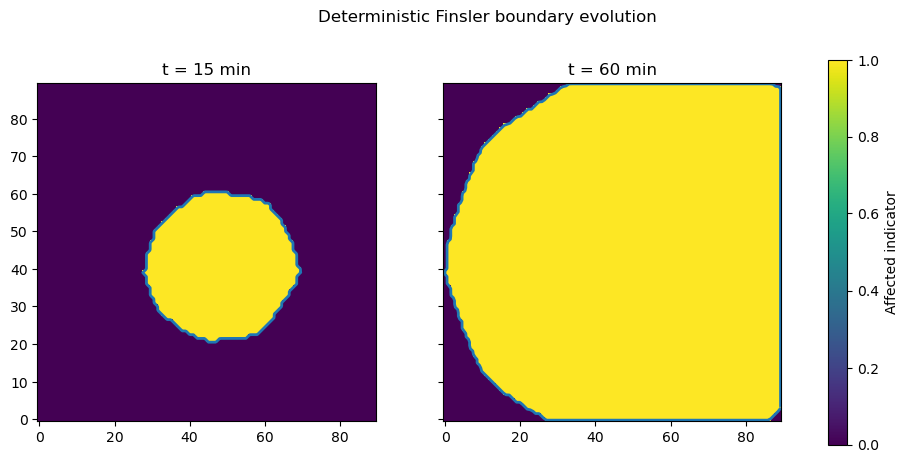

In [7]:
boundary_K = 360
p_boundary = 0.5  # threshold (not a probability in the deterministic model)

b_init = finsler.extract_fire_boundary(init_state, K=boundary_K, p_boundary=p_boundary, field="affected")
b_final = finsler.extract_fire_boundary(state_no_drop, K=boundary_K, p_boundary=p_boundary, field="affected")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
for ax, st, bd, label in [
    (axes[0], init_state, b_init, f"t = {drop_time_s/60:.0f} min"),
    (axes[1], state_no_drop, b_final, f"t = {(drop_time_s+eval_horizon_s)/60:.0f} min"),
]:
    field = ((st.burning[0] > 0.5) | (st.burned[0] > 0.5)).astype(float)
    im = ax.imshow(field.T, origin="lower", aspect="equal")
    ax.plot(bd.xy[:, 0], bd.xy[:, 1], linewidth=2)
    ax.set_title(label)
plt.colorbar(im, ax=axes.ravel().tolist(), label="Affected indicator")
plt.suptitle("Deterministic Finsler boundary evolution")
plt.show()


## 6. Search domain (between boundaries)

We optimise only over a band between the boundary at drop time and at the evaluation horizon.

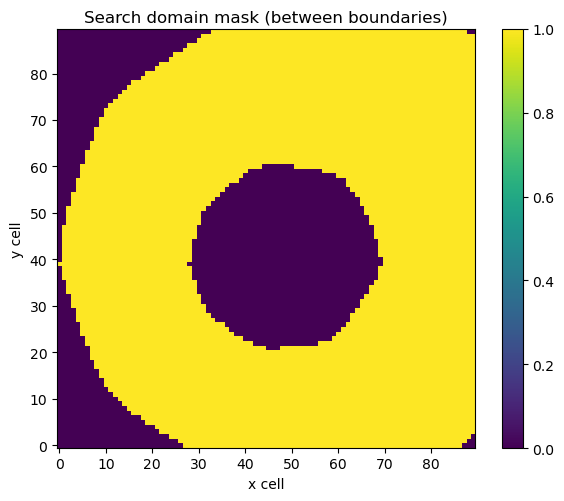

Valid search cells: 5976


In [8]:
search_mask = finsler.generate_search_domain(
    T=eval_horizon_s,
    init_firestate=init_state,
    p_boundary=0.5,
    K=300,
    boundary_field="affected",
)

plot_field(search_mask.astype(float), title="Search domain mask (between boundaries)")
xs_idx, ys_idx = np.where(search_mask)
coords = np.stack([xs_idx.astype(float), ys_idx.astype(float)], axis=1)
print("Valid search cells:", coords.shape[0])


## 7. Bayesian Optimisation (deterministic)

We minimise a deterministic objective:
- simulate Finsler to evaluation horizon with a candidate drop
- compute value-weighted burned area

Because the model is deterministic, the objective is deterministic (no Monte Carlo averaging).

In [14]:
from fire_model.bo import RetardantDropBayesOpt

drop_opt = RetardantDropBayesOpt(
    fire_model=finsler,
    init_firestate=init_state,
    n_drones=3,
    evolution_time_s=eval_horizon_s,
    n_sims=1,
    fire_boundary_probability=0.5,
)
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=3000,
    xi=0.01,
    verbose=True,
)

[BO] init: n_init=50, dim=9, n_cells=5976
[BO] init: best_y=9.98164, mean_y=10.4586, std_y=0.119289
[BO] iter 001/150 | y_next=10.511 | best_y=9.98164 (no-improve) | EI_max=5.93e-07 | mu=10.4585 | std=0.119
      proposed (x,y,phi) per drone:
      [[ 0.         39.          2.75330592]
 [ 2.         33.          2.96509868]
 [27.         29.          6.25527122]]
      gp.kernel_ = 0.0316**2 * TiedXYFiMatern(lx=0.639, ly=0.0303, lphi=43.6, nu=2.5) + WhiteKernel(noise_level=0.999)
[BO] iter 002/150 | y_next=10.4744 | best_y=9.98164 (no-improve) | EI_max=4.86e-07 | mu=10.4596 | std=0.118
      proposed (x,y,phi) per drone:
      [[16.         78.         -0.34723474]
 [22.         82.          4.44764803]
 [89.         30.          3.38868421]]
      gp.kernel_ = 0.996**2 * TiedXYFiMatern(lx=0.0167, ly=0.00662, lphi=0.0661, nu=2.5) + WhiteKernel(noise_level=0.00766)
[BO] iter 003/150 | y_next=10.5086 | best_y=9.98164 (no-improve) | EI_max=1.05e-06 | mu=10.4203 | std=0.114
      proposed

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 005/150 | y_next=10.1688 | best_y=9.98164 (no-improve) | EI_max=3.14e-05 | mu=10.3111 | std=0.11
      proposed (x,y,phi) per drone:
      [[ 0.         39.          3.24748904]
 [19.         59.          3.69512103]
 [27.          0.          3.95346491]]
      gp.kernel_ = 0.997**2 * TiedXYFiMatern(lx=0.0775, ly=1e+03, lphi=0.931, nu=2.5) + WhiteKernel(noise_level=1.05e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 006/150 | y_next=10.4128 | best_y=9.98164 (no-improve) | EI_max=0.000415 | mu=10.1838 | std=0.0948
      proposed (x,y,phi) per drone:
      [[ 0.         39.          3.81226974]
 [16.          7.          4.0240625 ]
 [23.         74.          5.59975568]]
      gp.kernel_ = 0.961**2 * TiedXYFiMatern(lx=0.085, ly=1e+03, lphi=1.22, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 007/150 | y_next=10.3847 | best_y=9.98164 (no-improve) | EI_max=0.00195 | mu=10.0978 | std=0.0799
      proposed (x,y,phi) per drone:
      [[26.         56.          3.88534867]
 [27.          0.          3.95346491]
 [70.         29.          4.5888432 ]]
      gp.kernel_ = 0.992**2 * TiedXYFiMatern(lx=0.099, ly=0.332, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 008/150 | y_next=10.3721 | best_y=9.98164 (no-improve) | EI_max=3.64e-05 | mu=10.3025 | std=0.109
      proposed (x,y,phi) per drone:
      [[ 0.         39.          3.88286732]
 [26.         24.          1.46814806]
 [78.          0.          3.81226974]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.0931, ly=0.434, lphi=1.35, nu=2.5) + WhiteKernel(noise_level=1.27e-06)
[BO] iter 009/150 | y_next=10.2804 | best_y=9.98164 (no-improve) | EI_max=0.000378 | mu=10.1874 | std=0.095
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.09466009]
 [27.          0.          3.9534649

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 011/150 | y_next=10.45 | best_y=9.98164 (no-improve) | EI_max=0.000138 | mu=10.2319 | std=0.0995
      proposed (x,y,phi) per drone:
      [[0.00000000e+00 3.90000000e+01 4.80063597e+00]
 [1.00000000e+01 1.30000000e+01 3.52987939e+00]
 [2.20000000e+01 6.30000000e+01 4.79281574e-02]]
      gp.kernel_ = 0.925**2 * TiedXYFiMatern(lx=0.0749, ly=0.434, lphi=1.32, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 012/150 | y_next=9.74617 | best_y=9.74617 (improved) | EI_max=1.01e-05 | mu=10.3345 | std=0.107
      proposed (x,y,phi) per drone:
      [[23.         21.          0.43313429]
 [54.          0.          4.44764803]
 [89.         30.          3.38868421]]
      gp.kernel_ = 0.799**2 * TiedXYFiMatern(lx=0.0993, ly=0.309, lphi=1.42, nu=2.5) + WhiteKernel(noise_level=0.251)
[BO] iter 013/150 | y_next=10.3949 | best_y=9.74617 (no-improve) | EI_max=6.33e-06 | mu=10.1992 | std=0.131
      proposed (x,y,phi) per drone:
      [[25.         17.          4.74283412]
 [63.         2

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 019/150 | y_next=10.3679 | best_y=9.74617 (no-improve) | EI_max=2.85e-08 | mu=10.3735 | std=0.135
      proposed (x,y,phi) per drone:
      [[18.         43.          5.34905915]
 [44.          0.          3.38868421]
 [48.         21.          3.38868421]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.0812, ly=0.343, lphi=0.796, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 020/150 | y_next=10.5241 | best_y=9.74617 (no-improve) | EI_max=3.55e-06 | mu=10.1971 | std=0.125
      proposed (x,y,phi) per drone:
      [[26.         17.         -1.8434369 ]
 [80.          0.          4.87123355]
 [85.         29.          3.17689145]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.0816, ly=0.34, lphi=0.797, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 021/150 | y_next=10.348 | best_y=9.74617 (no-improve) | EI_max=1.15e-07 | mu=10.3242 | std=0.132
      proposed (x,y,phi) per drone:
      [[23.         38.         -5.24767788]
 [49.         21.          2.96509868]
 [51.          0.          4.37705044]]
      gp.kernel_ = 0.44**2 * TiedXYFiMatern(lx=0.123, ly=1.59, lphi=2.32, nu=2.5) + WhiteKernel(noise_level=0.743)
[BO] iter 022/150 | y_next=10.5699 | best_y=9.74617 (no-improve) | EI_max=7.45e-08 | mu=10.3275 | std=0.13
      proposed (x,y,phi) per drone:
      [[ 2.         33.          4.16525768]
 [21.         34.          6.20561255]
 [27.

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 026/150 | y_next=10.3924 | best_y=9.74617 (no-improve) | EI_max=6.94e-08 | mu=10.3396 | std=0.132
      proposed (x,y,phi) per drone:
      [[ 0.         39.          3.17689145]
 [26.         21.         -5.80837397]
 [75.          0.          4.16525768]]
      gp.kernel_ = 0.381**2 * TiedXYFiMatern(lx=0.137, ly=0.558, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.811)
[BO] iter 027/150 | y_next=10.1754 | best_y=9.74617 (no-improve) | EI_max=3.56e-08 | mu=10.3523 | std=0.131
      proposed (x,y,phi) per drone:
      [[ 0.         39.          3.38868421]
 [21.         33.          4.76925689]
 [74.          0.          4.37705044]]
      gp.kernel_ = 0.38**2 * TiedXYFiMatern(lx=0.139, ly=0.61, lphi=4.62, nu=2.5) + WhiteKernel(noise_level=0.812)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 028/150 | y_next=10.507 | best_y=9.74617 (no-improve) | EI_max=1.2e-07 | mu=10.3151 | std=0.13
      proposed (x,y,phi) per drone:
      [[13.         10.          4.44764803]
 [24.         22.         -5.51598881]
 [39.         23.          3.38868421]]
      gp.kernel_ = 0.405**2 * TiedXYFiMatern(lx=0.125, ly=0.474, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.779)
[BO] iter 029/150 | y_next=10.3652 | best_y=9.74617 (no-improve) | EI_max=3.77e-08 | mu=10.3621 | std=0.134
      proposed (x,y,phi) per drone:
      [[ 0.         39.          3.38868421]
 [27.          0.          4.65944079]
 [29.         16.          2.39533338]]
      gp.kernel_ = 0.367**2 * TiedXYFiMatern(lx=0.145, ly=0.658, lphi=4.69, nu=2.5) + WhiteKernel(noise_level=0.824)
[BO] iter 030/150 | y_next=10.46 | best_y=9.74617 (no-improve) | EI_max=3.48e-08 | mu=10.3593 | std=0.133
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.23585526]
 [28.         42.          4.64342942]
 [75. 

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 057/150 | y_next=10.5708 | best_y=9.70741 (no-improve) | EI_max=4.4e-07 | mu=10.2757 | std=0.138
      proposed (x,y,phi) per drone:
      [[ 0.         39.          5.43601425]
 [27.          0.          3.4592818 ]
 [28.         40.          5.31544883]]
      gp.kernel_ = 0.947**2 * TiedXYFiMatern(lx=0.379, ly=0.0824, lphi=0.822, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 058/150 | y_next=10.2107 | best_y=9.70741 (no-improve) | EI_max=2.55e-07 | mu=10.3266 | std=0.146
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.87123355]
 [12.         36.         -1.73780477]
 [89.          8.          4.09466009]]
      gp.kernel_ = 0.956**2 * TiedXYFiMatern(lx=1e+03, ly=0.0672, lphi=0.859, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 059/150 | y_next=10.1382 | best_y=9.70741 (no-improve) | EI_max=2.83e-06 | mu=10.2113 | std=0.137
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.23585526]
 [ 6.         37.          3.84878991]
 [27.          0.          5.22422149]]
      gp.kernel_ = 0.954**2 * TiedXYFiMatern(lx=1e+03, ly=0.0677, lphi=0.904, nu=2.5) + WhiteKernel(noise_level=3.84e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 060/150 | y_next=10.4073 | best_y=9.70741 (no-improve) | EI_max=3.74e-06 | mu=10.2183 | std=0.141
      proposed (x,y,phi) per drone:
      [[ 2.         51.          4.23585526]
 [ 9.         42.         -3.50850273]
 [82.         35.          5.71840461]]
      gp.kernel_ = 0.945**2 * TiedXYFiMatern(lx=1e+03, ly=0.0692, lphi=0.915, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 061/150 | y_next=10.0304 | best_y=9.70741 (no-improve) | EI_max=5.19e-07 | mu=10.2912 | std=0.143
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.23585526]
 [28.         38.         -0.53457415]
 [49.          0.          2.96509868]]
      gp.kernel_ = 0.948**2 * TiedXYFiMatern(lx=971, ly=0.07, lphi=0.797, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 062/150 | y_next=10.379 | best_y=9.70741 (no-improve) | EI_max=1.36e-06 | mu=10.2679 | std=0.145
      proposed (x,y,phi) per drone:
      [[ 6.         22.          6.17558695]
 [16.         19.          3.24748904]
 [82.          0.          4.5888432 ]]
      gp.kernel_ = 0.941**2 * TiedXYFiMatern(lx=0.48, ly=0.0702, lphi=0.951, nu=2.5) + WhiteKernel(noise_level=1e-05)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 063/150 | y_next=10.1548 | best_y=9.70741 (no-improve) | EI_max=1.84e-06 | mu=10.2354 | std=0.139
      proposed (x,y,phi) per drone:
      [[21.         25.         -0.43190368]
 [27.          0.          6.00079496]
 [89.         28.          2.82390351]]
      gp.kernel_ = 0.943**2 * TiedXYFiMatern(lx=0.486, ly=0.0693, lphi=0.907, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 064/150 | y_next=10.4998 | best_y=9.70741 (no-improve) | EI_max=1.44e-06 | mu=10.2462 | std=0.14
      proposed (x,y,phi) per drone:
      [[ 1.         47.          4.23585526]
 [ 4.         43.          4.45086101]
 [83.          0.          4.5888432 ]]
      gp.kernel_ = 0.937**2 * TiedXYFiMatern(lx=0.54, ly=0.0712, lphi=0.901, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 065/150 | y_next=10.261 | best_y=9.70741 (no-improve) | EI_max=4.44e-07 | mu=10.312 | std=0.147
      proposed (x,y,phi) per drone:
      [[ 1.         47.          4.51824561]
 [29.         35.         -3.57219382]
 [70.          0.          4.51824561]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.308, ly=0.0716, lphi=0.944, nu=2.5) + WhiteKernel(noise_level=2.09e-06)
[BO] iter 066/150 | y_next=10.4205 | best_y=9.70741 (no-improve) | EI_max=6.77e-07 | mu=10.2334 | std=0.132
      proposed (x,y,phi) per drone:
      [[ 0.         39.          3.95346491]
 [ 5.         43.          4.9665239 ]

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 067/150 | y_next=10.5225 | best_y=9.70741 (no-improve) | EI_max=2.46e-07 | mu=10.3325 | std=0.147
      proposed (x,y,phi) per drone:
      [[ 1.         47.          4.44764803]
 [29.         35.         -5.13582336]
 [88.          2.          4.87123355]]
      gp.kernel_ = 0.948**2 * TiedXYFiMatern(lx=0.248, ly=0.0718, lphi=0.987, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 068/150 | y_next=10.0569 | best_y=9.70741 (no-improve) | EI_max=7.15e-06 | mu=10.2087 | std=0.144
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.44764803]
 [26.         41.         -2.88100641]
 [30.          0.          3.03569627]]
      gp.kernel_ = 0.95**2 * TiedXYFiMatern(lx=0.247, ly=0.0698, lphi=0.96, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 069/150 | y_next=10.3806 | best_y=9.70741 (no-improve) | EI_max=9e-06 | mu=10.1867 | std=0.141
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.65944079]
 [11.         46.         -0.48965522]
 [27.          0.          4.65944079]]
      gp.kernel_ = 0.94**2 * TiedXYFiMatern(lx=0.256, ly=0.0681, lphi=1.07, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 070/150 | y_next=10.5089 | best_y=9.70741 (no-improve) | EI_max=8.55e-07 | mu=10.2877 | std=0.146
      proposed (x,y,phi) per drone:
      [[11.         20.          3.06483853]
 [78.         29.          3.17689145]
 [86.          0.          4.44764803]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.217, ly=0.0648, lphi=1.08, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 071/150 | y_next=10.2721 | best_y=9.70741 (no-improve) | EI_max=2.75e-06 | mu=10.2278 | std=0.141
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.51824561]
 [14.         44.          0.22387046]
 [86.          0.          4.51824561]]
      gp.kernel_ = 0.948**2 * TiedXYFiMatern(lx=0.216, ly=0.0668, lphi=0.967, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 072/150 | y_next=10.414 | best_y=9.70741 (no-improve) | EI_max=2.48e-06 | mu=10.2444 | std=0.144
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.5888432 ]
 [22.          3.          2.68270833]
 [28.         40.         -2.48236017]]
      gp.kernel_ = 0.947**2 * TiedXYFiMatern(lx=0.212, ly=0.0662, lphi=0.968, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 073/150 | y_next=10.4962 | best_y=9.70741 (no-improve) | EI_max=5.89e-07 | mu=10.3097 | std=0.148
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.37705044]
 [16.         42.         -4.10747309]
 [70.         55.          3.38868421]]
      gp.kernel_ = 0.951**2 * TiedXYFiMatern(lx=0.215, ly=0.0636, lphi=0.93, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 074/150 | y_next=10.6101 | best_y=9.70741 (no-improve) | EI_max=5.36e-07 | mu=10.2905 | std=0.143
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.23585526]
 [19.          5.          3.38868421]
 [29.         45.         -3.85163918]]
      gp.kernel_ = 0.953**2 * TiedXYFiMatern(lx=0.223, ly=0.064, lphi=0.862, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 075/150 | y_next=10.4589 | best_y=9.70741 (no-improve) | EI_max=5.11e-07 | mu=10.3229 | std=0.15
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.30645285]
 [14.         44.          5.41423077]
 [88.         10.          2.54151316]]
      gp.kernel_ = 0.962**2 * TiedXYFiMatern(lx=0.237, ly=0.0608, lphi=0.807, nu=2.5) + WhiteKernel(noise_level=1.12e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 076/150 | y_next=10.4413 | best_y=9.70741 (no-improve) | EI_max=4.09e-07 | mu=10.3151 | std=0.147
      proposed (x,y,phi) per drone:
      [[ 0.         39.          5.01242873]
 [10.         13.          3.52987939]
 [19.         40.          2.83644423]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.209, ly=0.0642, lphi=0.777, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 077/150 | y_next=10.2054 | best_y=9.70741 (no-improve) | EI_max=3.88e-07 | mu=10.3098 | std=0.145
      proposed (x,y,phi) per drone:
      [[21.         24.          3.84966258]
 [70.         26.          2.8945011 ]
 [82.          0.          4.16525768]]
      gp.kernel_ = 0.965**2 * TiedXYFiMatern(lx=0.209, ly=0.0665, lphi=0.733, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 078/150 | y_next=10.3656 | best_y=9.70741 (no-improve) | EI_max=7.9e-07 | mu=10.2979 | std=0.148
      proposed (x,y,phi) per drone:
      [[ 0.         39.          5.08302632]
 [25.         46.          0.47241755]
 [72.          0.          2.96509868]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.198, ly=0.0707, lphi=0.726, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 079/150 | y_next=10.5646 | best_y=9.70741 (no-improve) | EI_max=5.78e-07 | mu=10.2988 | std=0.146
      proposed (x,y,phi) per drone:
      [[ 1.         47.          4.16525768]
 [27.         44.          5.7965327 ]
 [78.          0.          4.94183114]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.203, ly=0.0664, lphi=0.747, nu=2.5) + WhiteKernel(noise_level=3.36e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 080/150 | y_next=9.85907 | best_y=9.70741 (no-improve) | EI_max=4.25e-07 | mu=10.316 | std=0.147
      proposed (x,y,phi) per drone:
      [[ 0.         39.          3.88286732]
 [22.         42.          4.90445228]
 [60.          0.          3.67107456]]
      gp.kernel_ = 0.967**2 * TiedXYFiMatern(lx=0.155, ly=0.0762, lphi=0.699, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 081/150 | y_next=10.4026 | best_y=9.70741 (no-improve) | EI_max=1.24e-06 | mu=10.3037 | std=0.153
      proposed (x,y,phi) per drone:
      [[10.         20.          4.06029132]
 [68.         28.          2.8945011 ]
 [84.          0.          4.37705044]]
      gp.kernel_ = 0.963**2 * TiedXYFiMatern(lx=0.133, ly=0.078, lphi=0.778, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 082/150 | y_next=10.2565 | best_y=9.70741 (no-improve) | EI_max=4.71e-07 | mu=10.3487 | std=0.155
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.30645285]
 [19.         42.          1.34059605]
 [89.          7.          4.30645285]]
      gp.kernel_ = 0.964**2 * TiedXYFiMatern(lx=0.13, ly=0.0764, lphi=0.783, nu=2.5) + WhiteKernel(noise_level=1.46e-06)
[BO] iter 083/150 | y_next=10.2276 | best_y=9.70741 (no-improve) | EI_max=4.47e-07 | mu=10.3501 | std=0.155
      proposed (x,y,phi) per drone:
      [[19.         24.          1.24239752]
 [27.          0.          3.7416721

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 085/150 | y_next=10.208 | best_y=9.70741 (no-improve) | EI_max=3.76e-07 | mu=10.3499 | std=0.154
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.37705044]
 [ 4.         27.          3.4592818 ]
 [27.         43.          2.89706224]]
      gp.kernel_ = 0.954**2 * TiedXYFiMatern(lx=0.125, ly=0.0797, lphi=0.831, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 086/150 | y_next=10.5844 | best_y=9.70741 (no-improve) | EI_max=5.14e-07 | mu=10.3464 | std=0.156
      proposed (x,y,phi) per drone:
      [[ 8.         17.          3.49377985]
 [16.          7.          3.74167215]
 [74.         30.          3.38868421]]
      gp.kernel_ = 0.954**2 * TiedXYFiMatern(lx=0.12, ly=0.0787, lphi=0.864, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 087/150 | y_next=9.80541 | best_y=9.70741 (no-improve) | EI_max=1.52e-06 | mu=10.3031 | std=0.154
      proposed (x,y,phi) per drone:
      [[25.         28.          1.53428987]
 [27.          0.          5.29481908]
 [86.         29.          3.4592818 ]]
      gp.kernel_ = 0.955**2 * TiedXYFiMatern(lx=0.114, ly=0.0807, lphi=0.854, nu=2.5) + WhiteKernel(noise_level=2.07e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 088/150 | y_next=10.1193 | best_y=9.70741 (no-improve) | EI_max=2.7e-06 | mu=10.3067 | std=0.16
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.0240625 ]
 [27.          0.          3.81226974]
 [29.         45.          5.26839126]]
      gp.kernel_ = 0.953**2 * TiedXYFiMatern(lx=0.116, ly=0.0829, lphi=0.889, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 089/150 | y_next=10.3161 | best_y=9.70741 (no-improve) | EI_max=2.97e-06 | mu=10.3019 | std=0.16
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.30645285]
 [16.          7.          3.74167215]
 [21.         53.          1.14685999]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=0.114, ly=0.082, lphi=0.931, nu=2.5) + WhiteKernel(noise_level=1.51e-06)
[BO] iter 090/150 | y_next=10.039 | best_y=9.70741 (no-improve) | EI_max=5.48e-06 | mu=10.2789 | std=0.16
      proposed (x,y,phi) per drone:
      [[26.         24.          3.62857266]
 [27.          0.          5.78900219]
 

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 092/150 | y_next=10.3229 | best_y=9.70741 (no-improve) | EI_max=1.72e-06 | mu=10.3337 | std=0.163
      proposed (x,y,phi) per drone:
      [[ 0.         39.          6.14199013]
 [17.         21.          3.02133429]
 [78.         23.          2.82390351]]
      gp.kernel_ = 0.948**2 * TiedXYFiMatern(lx=0.113, ly=0.0851, lphi=0.946, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 093/150 | y_next=10.3358 | best_y=9.70741 (no-improve) | EI_max=9.77e-06 | mu=10.2583 | std=0.161
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.16525768]
 [28.         36.          1.93244771]
 [87.         19.          3.74167215]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.113, ly=0.085, lphi=0.947, nu=2.5) + WhiteKernel(noise_level=1.21e-06)
[BO] iter 094/150 | y_next=10.0834 | best_y=9.70741 (no-improve) | EI_max=1.92e-05 | mu=10.2139 | std=0.156
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.23585526]
 [30.         48.         -0.149649

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 095/150 | y_next=10.1313 | best_y=9.70741 (no-improve) | EI_max=7.34e-06 | mu=10.2533 | std=0.156
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.44764803]
 [27.         48.         -0.36057385]
 [64.          0.          4.30645285]]
      gp.kernel_ = 0.944**2 * TiedXYFiMatern(lx=0.112, ly=0.0876, lphi=0.932, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 096/150 | y_next=10.1882 | best_y=9.70741 (no-improve) | EI_max=2.8e-06 | mu=10.3122 | std=0.162
      proposed (x,y,phi) per drone:
      [[12.         28.         -2.64836114]
 [27.          0.          4.94183114]
 [81.         29.          3.52987939]]
      gp.kernel_ = 0.942**2 * TiedXYFiMatern(lx=0.113, ly=0.0901, lphi=0.922, nu=2.5) + WhiteKernel(noise_level=8.87e-06)
[BO] iter 097/150 | y_next=10.2447 | best_y=9.70741 (no-improve) | EI_max=1.22e-05 | mu=10.1898 | std=0.145
      proposed (x,y,phi) per drone:
      [[18.         33.          2.78870582]
 [27.          0.          4.941831

/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 102/150 | y_next=10.3504 | best_y=9.70741 (no-improve) | EI_max=5.07e-06 | mu=10.2871 | std=0.161
      proposed (x,y,phi) per drone:
      [[15.         17.          4.14571767]
 [27.          0.          5.50661184]
 [67.         31.          3.88286732]]
      gp.kernel_ = 0.93**2 * TiedXYFiMatern(lx=0.118, ly=0.0865, lphi=0.971, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 103/150 | y_next=10.5418 | best_y=9.70741 (no-improve) | EI_max=3.53e-05 | mu=10.1787 | std=0.153
      proposed (x,y,phi) per drone:
      [[ 0.         39.          4.51824561]
 [28.         42.         -4.12278801]
 [62.          0.          4.30645285]]
      gp.kernel_ = 0.93**2 * TiedXYFiMatern(lx=0.117, ly=0.0854, lphi=0.973, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO] iter 104/150 | y_next=10.1383 | best_y=9.70741 (no-improve) | EI_max=3.76e-05 | mu=10.1597 | std=0.148
      proposed (x,y,phi) per drone:
      [[17.         22.          1.39725431]
 [27.          0.          4.94183114]
 [87.         29.          3.52987939]]
      gp.kernel_ = 0.939**2 * TiedXYFiMatern(lx=0.112, ly=0.0946, lphi=0.844, nu=2.5) + WhiteKernel(noise_level=2.23e-06)
[BO] iter 105/150 | y_next=10.5122 | best_y=9.70741 (no-improve) | EI_max=3.39e-06 | mu=10.2933 | std=0.159
      proposed (x,y,phi) per drone:
      [[7.00000000e+00 2.50000000e+01 2.82830476e-02]
 [2.20000000e+01 3.0000000

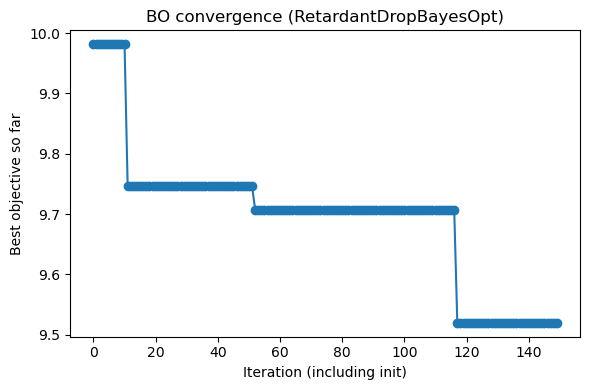

In [15]:
plt.figure(figsize=(6,4))
plt.plot(y_bests, marker='o')
plt.xlabel('Iteration (including init)')
plt.ylabel('Best objective so far')
plt.title('BO convergence (RetardantDropBayesOpt)')
plt.tight_layout()
plt.show()


## 8. Visualise the best solution

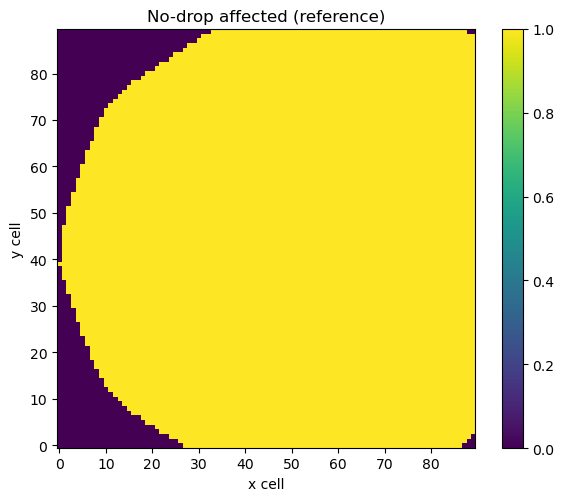

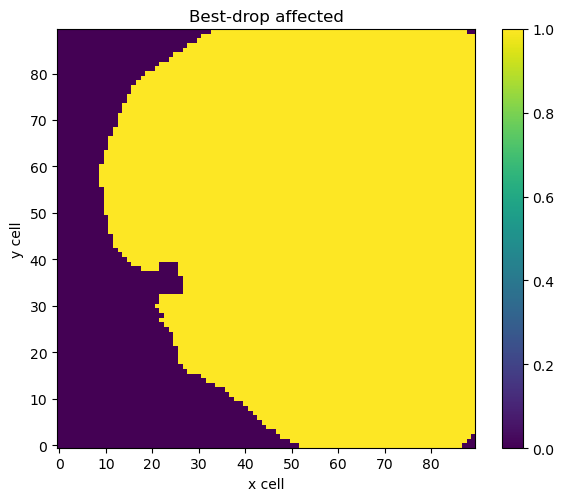

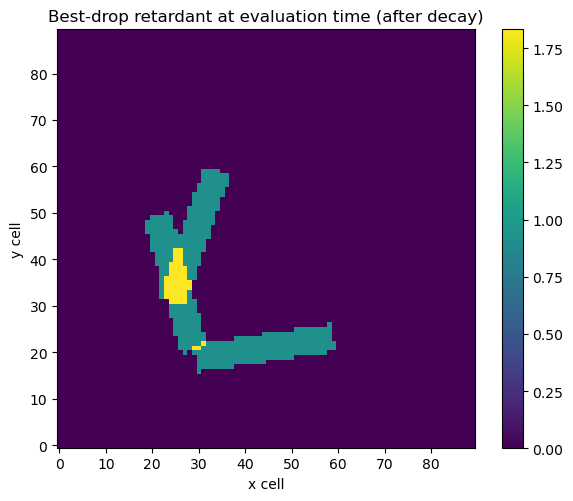

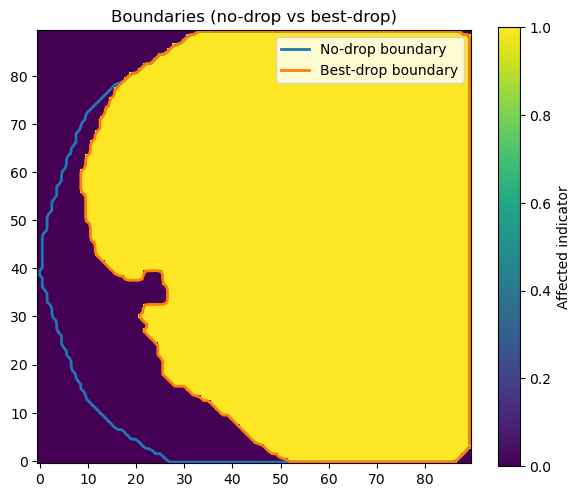

In [16]:
best_state = finsler.simulate_from_firestate(init_state, T=eval_horizon_s, drone_params=best_params)

plot_firestate(state_no_drop, kind="affected", title="No-drop affected (reference)")
plot_firestate(best_state, kind="affected", title="Best-drop affected")
plot_firestate(best_state, kind="retardant", title="Best-drop retardant at evaluation time (after decay)")

# Overlay boundaries for comparison
b0 = finsler.extract_fire_boundary(state_no_drop, K=360, p_boundary=0.5, field="affected")
b1 = finsler.extract_fire_boundary(best_state, K=360, p_boundary=0.5, field="affected")

plt.figure(figsize=(6,5))
field = ((best_state.burning[0] > 0.5) | (best_state.burned[0] > 0.5)).astype(float)
im = plt.imshow(field.T, origin="lower", aspect="equal")
plt.plot(b0.xy[:,0], b0.xy[:,1], linewidth=2, label="No-drop boundary")
plt.plot(b1.xy[:,0], b1.xy[:,1], linewidth=2, label="Best-drop boundary")
plt.legend()
plt.colorbar(im, label="Affected indicator")
plt.title("Boundaries (no-drop vs best-drop)")
plt.tight_layout()
plt.show()
